In [1]:
%matplotlib inline
from IPython.display import HTML, display

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.
<style>
.output {
    display: flex;
    align-items: center;
    text-align: center;
}
</style>
''')

In [2]:
from matplotlib import pyplot as plt
#plt.style.use('seaborn-darkgrid')
#plt.rcParams["lines.linewidth"] = 3
# import seaborn as sns
# sns.set()
# sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

import torch

import numpy as np
from cassie import CassieEnv

from rl.policies import GaussianMLP
from rl.envs import normalize

env = CassieEnv("walking", clock_based=True)
traj = env.trajectory

policy = torch.load("XieNew.pt")

policy.training = False

In [3]:
from collections import defaultdict

@torch.no_grad()
def get_trajectory_data(trj_len):
    data = defaultdict(lambda: [])
    
    state = torch.Tensor(env.reset())
    for t in range(trj_len):
        v, action = policy.act(state, True)
        v, action = v.numpy(), action.numpy()
        
        next_state, reward, done, _ = env.step(action)
        
        data["qpos"]    += [np.copy(env.sim.qpos())]
        data["qvel"]    += [np.copy(env.sim.qvel())]
        
        rpos, rvel = env.get_ref_state(env.phase)
        
        data["rpos"]    += [rpos]
        data["rvel"]    += [rvel]
        
        data["u_ref"]   += [rpos[env.pos_idx]]
        
        data["u_delta"] += [action]
        
        data["s"]       += [next_state]
        
        data["reward"]  += [reward]
        
        forces = np.zeros((12))
        env.sim.foot_force(forces)
        
        data["ff_left"]  += [forces[2]] # left foot z GRF
        data["ff_right"] += [forces[8]] # right foot z GRF
        
        fpos = np.zeros((6))
        env.sim.foot_pos(fpos)
        
        data["fp_left"]  += [fpos[:3]] # left foot z pos
        data["fp_right"] += [fpos[3:]] # right foot z pos
        
        if done:
           print("Warning: hit terminal state at step {}".format(t))
           break
            
        state = torch.Tensor(next_state)

    data = dict((k, np.array(v)) for k,v in data.items())

    return data


Time varying trajectory for one full phase.

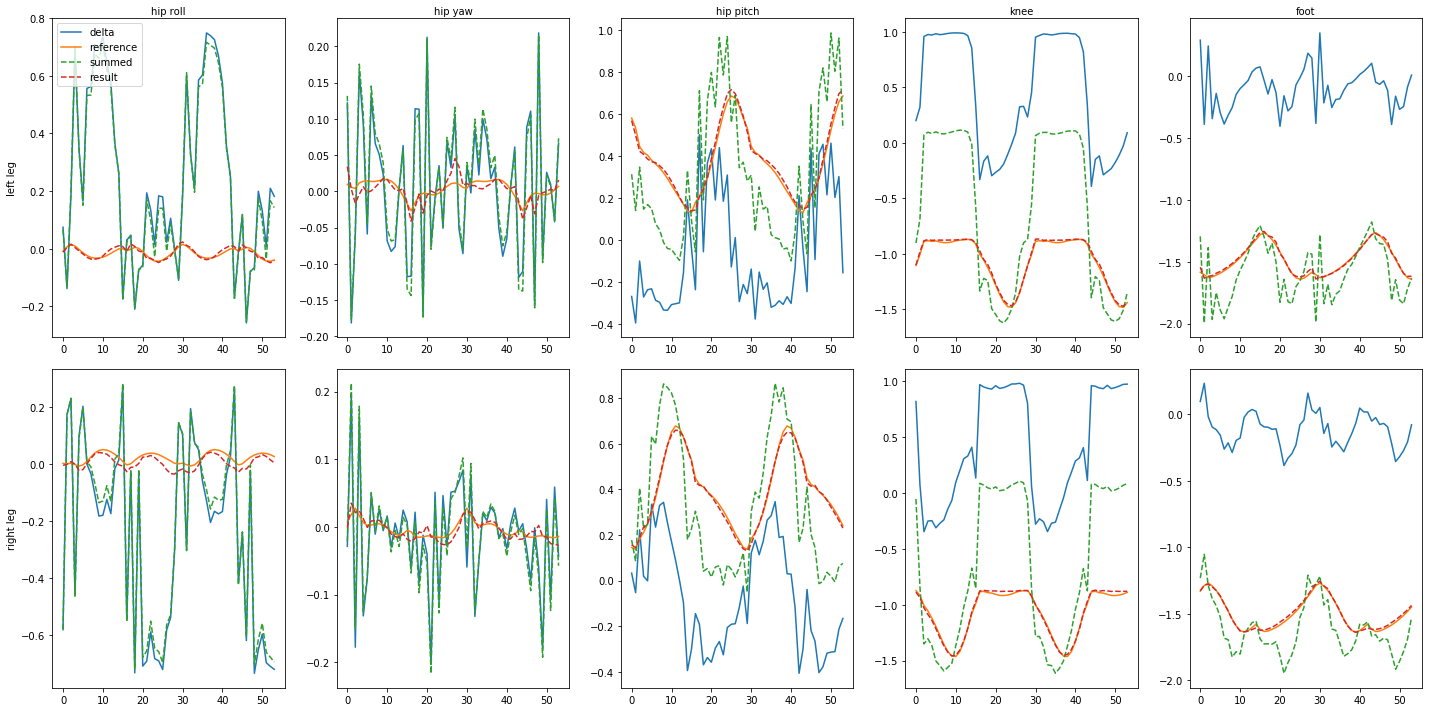

In [4]:
def plot_policy(data, title=None):
    cassie_action = ["hip roll", "hip yaw", "hip pitch", "knee", "foot"]

    # one row for each leg
    plot_rows = 2 
    plot_cols = 10 // 2

    fig, axes = plt.subplots(plot_rows, plot_cols, figsize=(20, 10))

    if title is not None:
        fig.suptitle(title, fontsize=16)
        
    trj_len = len(data["s"])

    for r in range(plot_rows):     # 2 legs
        for c in range(plot_cols): # 5 actions
            a = r * plot_cols + c
            axes[r][c].plot(np.arange(trj_len), data["u_delta"][:, a], "C0", label="delta")
            axes[r][c].plot(np.arange(trj_len), data["u_ref"][:, a], "C1", label="reference")
            axes[r][c].plot(np.arange(trj_len), data["u_delta"][:, a] + data["u_ref"][:, a], "C2--", label="summed")

            axes[r][c].plot(np.arange(trj_len), data["qpos"][:, env.pos_idx][:, a], "C3--", label="result")

            axes[0][c].set_xlabel(cassie_action[c])
            axes[0][c].xaxis.set_label_position('top') 
        axes[r][0].set_ylabel(["left leg", "right leg"][r])
    
    plt.tight_layout()

    if title is not None:
        plt.subplots_adjust(top=0.93)

    axes[0][0].legend(loc='upper left')

data = get_trajectory_data(2*env.phaselen)

plot_policy(data)

Phase portraits for left and right knee angles.

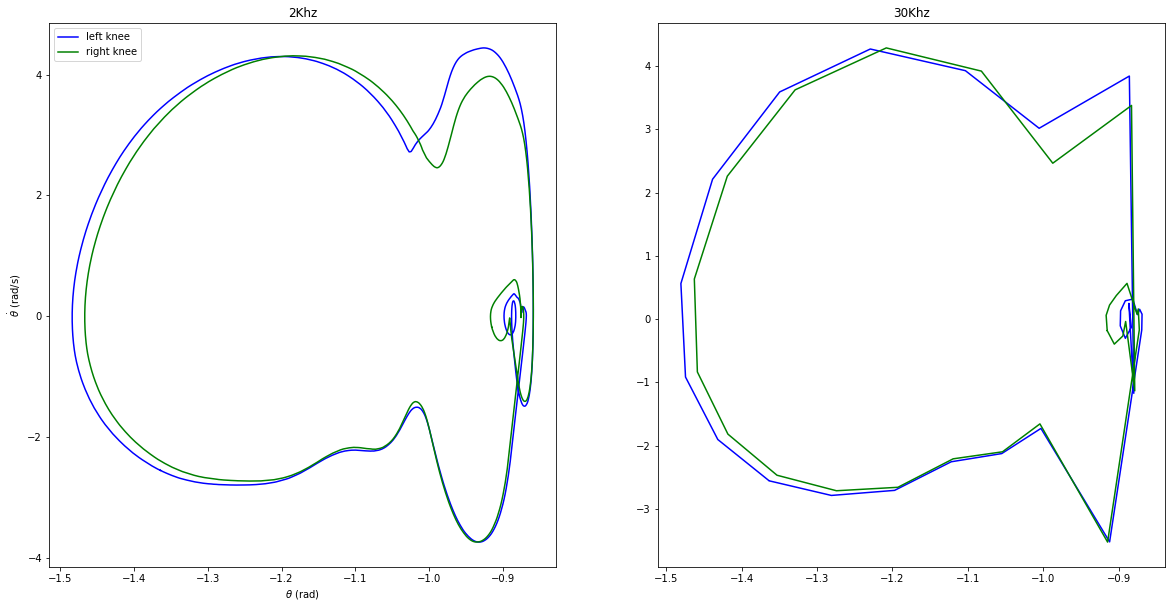

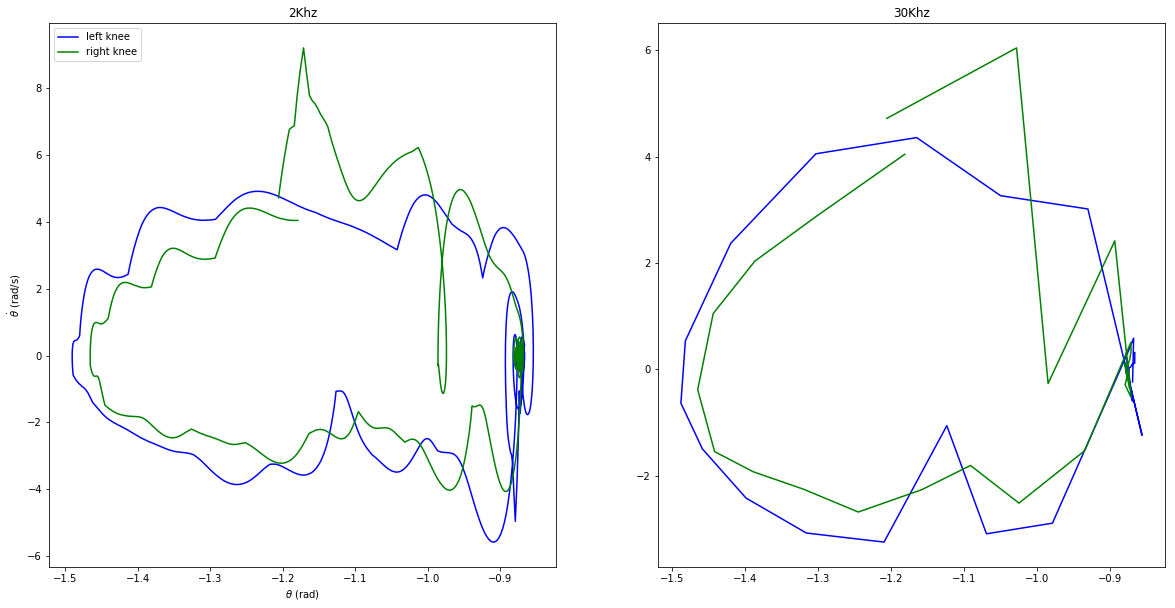

In [5]:
@torch.no_grad()
def plot_phase_portrait():
    qpos = np.copy(traj.qpos)
    qvel = np.copy(traj.qvel)
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    
    # down sample trajectory to simrate
    traj_len = qpos.shape[0]
    sub = [t for t in range(traj_len) if t % env.simrate == 0]

    # left leg
    axes[0].plot(qpos[:, 14], qvel[:, 12], "b", label="left knee")
    axes[1].plot(qpos[sub, 14], qvel[sub, 12], "b", label="left knee")
    
    #right leg
    axes[0].plot(qpos[:, 28], qvel[:, 25], "g", label="right knee")
    axes[1].plot(qpos[sub, 28], qvel[sub, 25], "g", label="right knee")

    axes[0].set_ylabel(r"$\dot{\theta}$ (rad/s)")
    axes[0].set_xlabel(r"$\theta$ (rad)")
    
    axes[0].set_title(r"2Khz")
    axes[1].set_title(r"30Khz")
    
    axes[0].legend(loc='upper left')
    
    left_x, left_x_dot = [], []
    right_x, right_x_dot = [], []
    
    # get the full resolution phase portrait
    env.reset()
    for t in range(traj_len):

        if t % env.simrate == 0:
            state = torch.Tensor(env.get_full_state())

            v, action = policy.act(state, True)
            v, action = v.numpy(), action.numpy()

            env.time  += 1
            env.phase += 1

            if env.phase > env.phaselen:
                env.phase = 0
                env.counter += 1

        env.step_simulation(action)
        left_x.append(env.sim.qpos()[14])
        left_x_dot.append(env.sim.qvel()[12])
        
        right_x.append(env.sim.qpos()[28])
        right_x_dot.append(env.sim.qvel()[25])
    
    left_x, left_x_dot = np.array(left_x), np.array(left_x_dot)
    right_x, right_x_dot = np.array(right_x), np.array(right_x_dot)
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    
    axes[0].plot(left_x, left_x_dot, "b", label="left knee")
    axes[0].plot(right_x, right_x_dot, "g", label="right knee")
        
    axes[1].plot(left_x[sub], left_x_dot[sub], "b", label="left knee")
    axes[1].plot(right_x[sub], right_x_dot[sub], "g", label="right knee")
    
    axes[0].set_ylabel(r"$\dot{\theta}$ (rad/s)")
    axes[0].set_xlabel(r"$\theta$ (rad)")
    
    axes[0].set_title(r"2Khz")
    axes[1].set_title(r"30Khz")
    
    axes[0].legend(loc='upper left')


plot_phase_portrait()

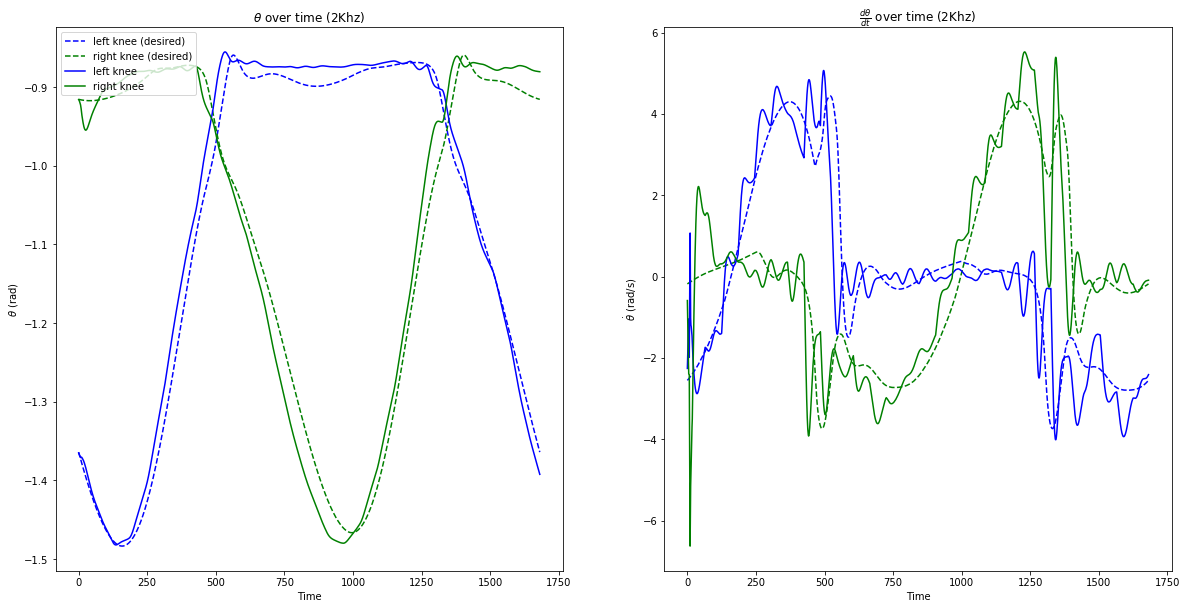

In [6]:
@torch.no_grad()
def plot_phase_states():
    qpos = np.copy(traj.qpos)
    qvel = np.copy(traj.qvel)
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
     
    # down sample trajectory to simrate
    traj_len = qpos.shape[0]

    # full resolution
    axes[0].plot(np.arange(traj_len), qpos[:, 14], "b--", label="left knee (desired)")
    axes[0].plot(np.arange(traj_len), qpos[:, 28], "g--", label="right knee (desired)")
    
    axes[1].plot(np.arange(traj_len), qvel[:, 12], "b--", label="left knee (desired)")
    axes[1].plot(np.arange(traj_len), qvel[:, 25], "g--", label="right knee (desired)")

    axes[0].set_ylabel(r"$\theta$ (rad)")
    axes[0].set_xlabel(r"Time")
    
    axes[1].set_ylabel(r"$\dot{\theta}$ (rad/s)")
    axes[1].set_xlabel(r"Time")
        
    axes[0].set_title(r"$\theta$ over time (2Khz)")
    axes[1].set_title(r"$\frac{d\theta}{dt}$ over time (2Khz)")
    
    axes[0].legend(loc='upper left')
        
    left_x, left_x_dot = [], []
    right_x, right_x_dot = [], []
    
    # get the full resolution phase portrait
    env.reset_for_test()
    for t in range(traj_len):

        if t % env.simrate == 0:
            state = torch.Tensor(env.get_full_state())

            v, action = policy.act(state, True)
            v, action = v.numpy(), action.numpy()

            env.time  += 1
            env.phase += 1

            if env.phase > env.phaselen:
                env.phase = 0
                env.counter += 1

        env.step_simulation(action)
        left_x.append(env.sim.qpos()[14])
        left_x_dot.append(env.sim.qvel()[12])
        
        right_x.append(env.sim.qpos()[28])
        right_x_dot.append(env.sim.qvel()[25])
    
    left_x, left_x_dot = np.array(left_x), np.array(left_x_dot)
    right_x, right_x_dot = np.array(right_x), np.array(right_x_dot)
    
    #fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # full resolution positions
    axes[0].plot(np.arange(traj_len), left_x, "b", label="left knee")
    axes[0].plot(np.arange(traj_len), right_x, "g", label="right knee")
    
    # full resolution velocities
    axes[1].plot(np.arange(traj_len), left_x_dot, "b", label="left knee")
    axes[1].plot(np.arange(traj_len), right_x_dot, "g", label="left knee")

    axes[0].set_ylabel(r"$\theta$ (rad)")
    axes[0].set_xlabel(r"Time")
    
    axes[1].set_ylabel(r"$\dot{\theta}$ (rad/s)")
    axes[1].set_xlabel(r"Time")

    axes[0].legend(loc='upper left')


plot_phase_states()

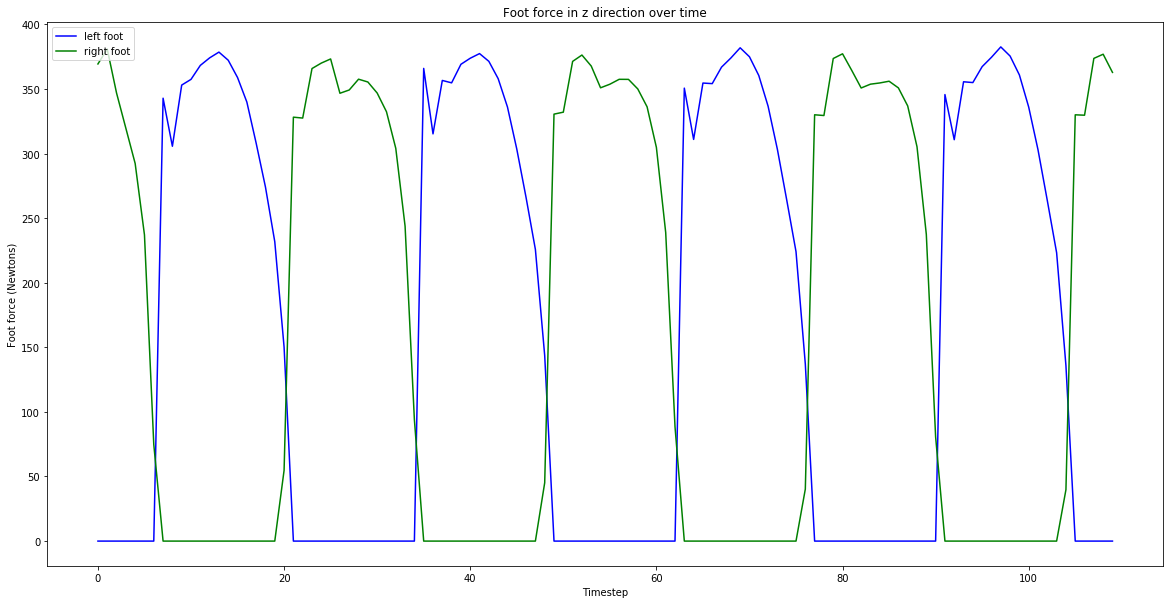

In [7]:
def plot_foot_forces(data):
    fig = plt.figure(figsize=(20, 10))
    ax = fig.gca()
    
    ax.plot(np.arange(len(data["ff_left"])), data["ff_left"], label="left foot", color="b")
    ax.plot(np.arange(len(data["ff_right"])), data["ff_right"], label="right foot", color="g")
    
    ax.set_ylabel(r"Foot force (Newtons)")
    ax.set_xlabel(r"Timestep")
    ax.set_title("Foot force in z direction over time")
    
    ax.legend(loc='upper left')

data = get_trajectory_data(110)
plot_foot_forces(data)

<IPython.core.display.Javascript object>


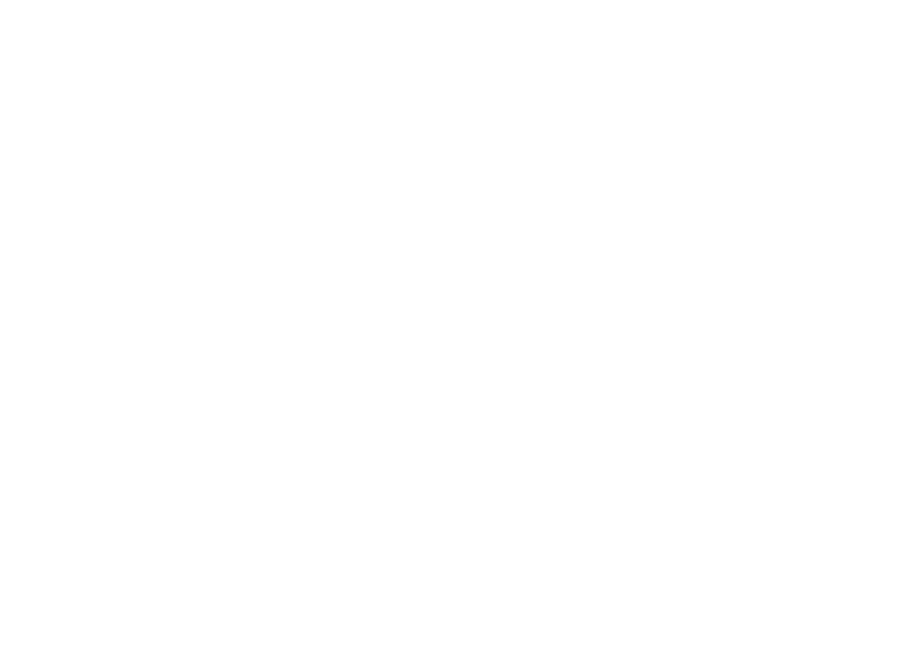

<IPython.core.display.Javascript object>


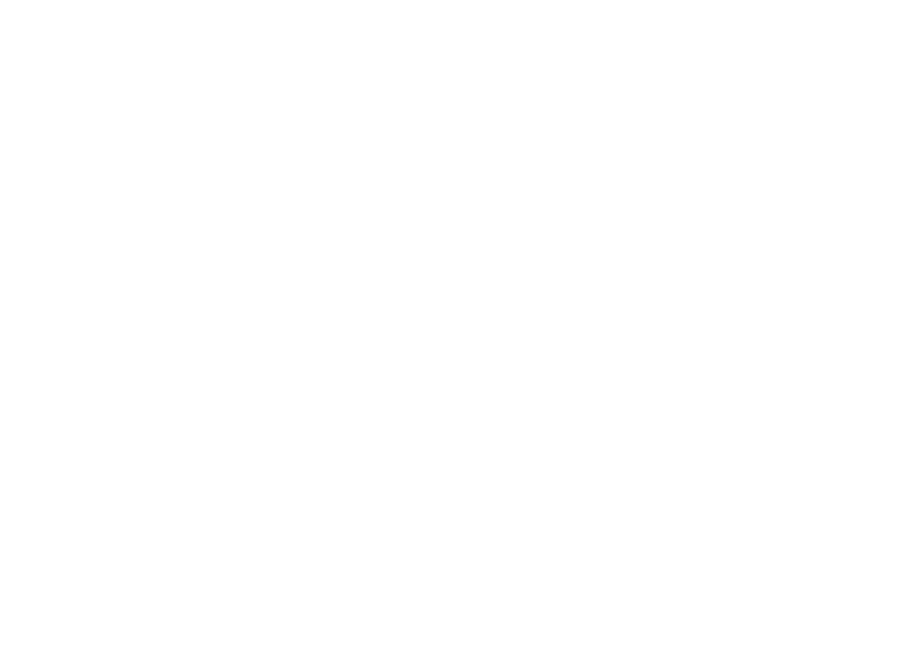

In [8]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_foot_positions3d(data):
    fig = plt.figure(figsize=(14, 10))
    ax = fig.gca(projection="3d")
    
    #ax.plot(np.arange(len(data["fp_left"])), data["fp_left"], label="left foot")
    #ax.plot(np.arange(len(data["fp_right"])), data["fp_right"], label="right foot")
    
    # left foot trajectory
    X, Y, Z = data["fp_left"][:, 0], data["fp_left"][:, 1], data["fp_left"][:, 2]
    ax.plot(X, Y, Z, "b")
    
    # right foot trajectory
    X, Y, Z = data["fp_right"][:, 0], data["fp_right"][:, 1], data["fp_right"][:, 2]
    ax.plot(X, Y, Z, "g")
    
    # COM trajectory
    X, Y, Z = data["qpos"][:, 0], data["qpos"][:, 1], data["qpos"][:, 2]
    ax.plot(X, Y, Z, "r")
    
    ax.set_xlabel(r"X (meters)")
    ax.set_ylabel(r"Y (meters)")
    ax.set_zlabel(r"Z (meters)")
    
    ax.axis('equal')

    #ax.set_xlabel(r"Timestep")
    #ax.set_title("Foot force in z direction over time")
    
    #ax.legend(loc='upper left')
data = get_trajectory_data(90)
plot_foot_positions3d(data)

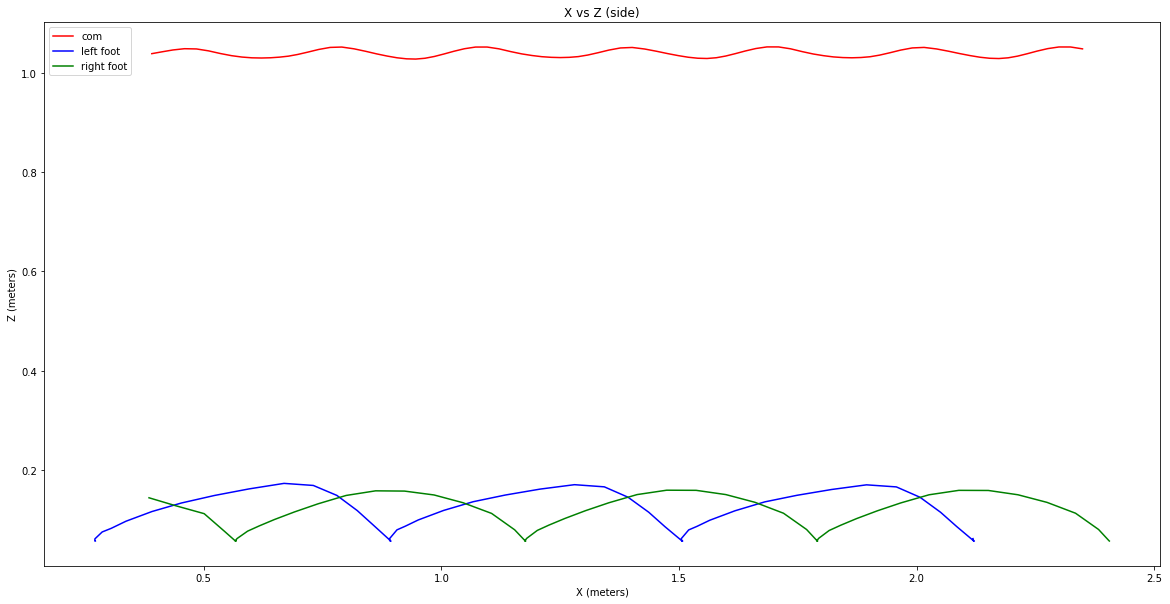

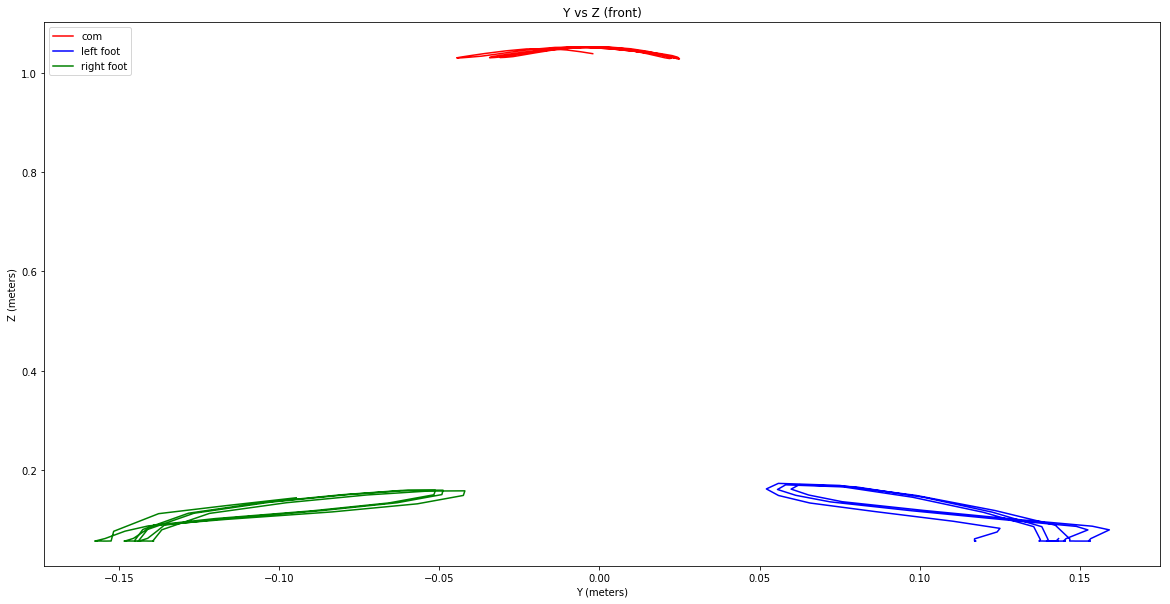

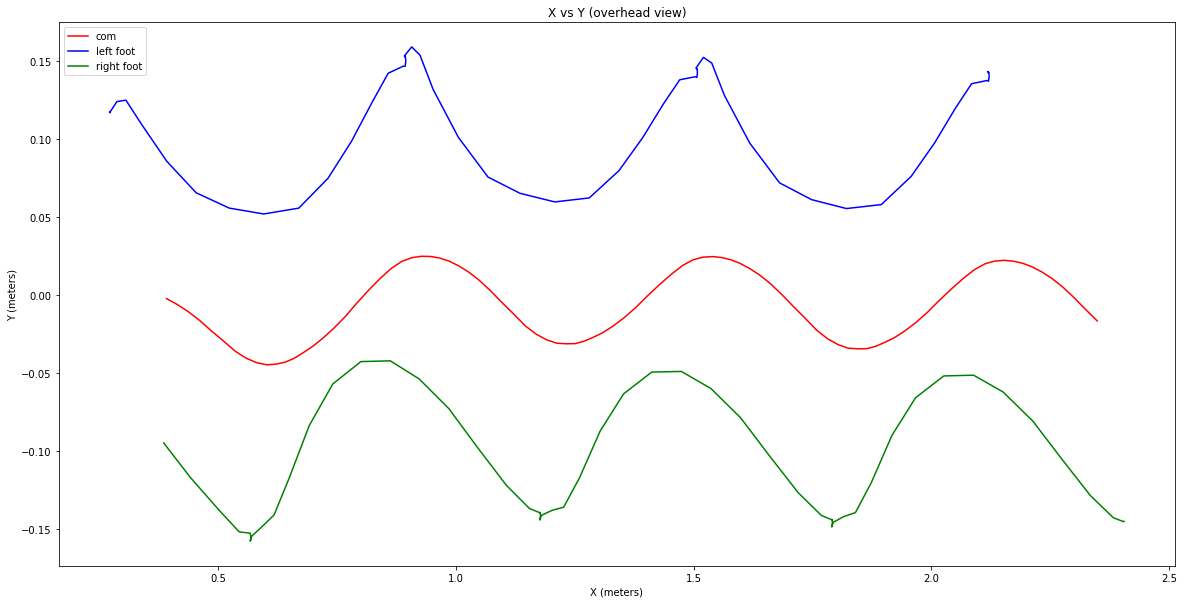

In [9]:
%matplotlib inline
from matplotlib import pyplot as plt

def plot_foot_positions2d(data, last=0):        
    # left foot trajectory
    left = data["fp_left"][-last:, 0], data["fp_left"][-last:, 1], data["fp_left"][-last:, 2]
    
    # right foot trajectory
    right = data["fp_right"][-last:, 0], data["fp_right"][-last:, 1], data["fp_right"][-last:, 2]
    
    # COM trajectory
    com = data["qpos"][-last:, 0], data["qpos"][-300:, 1], data["qpos"][-last:, 2]
    
    # XZ PLOT
    fig = plt.figure(figsize=(20, 10))
    ax = fig.gca()
    
    ax.plot(com[0], com[2], "r", label="com")
    ax.plot(left[0], left[2], "b", label="left foot")
    ax.plot(right[0], right[2], "g", label="right foot")
    
    ax.set_title("X vs Z (side)")
    ax.set_xlabel(r"X (meters)")
    ax.set_ylabel(r"Z (meters)")
    
    ax.legend(loc='upper left')
    
    # YZ PLOT
    fig = plt.figure(figsize=(20, 10))
    ax = fig.gca()
    
    ax.plot(com[1], com[2], "r", label="com")
    ax.plot(left[1], left[2], "b", label="left foot")
    ax.plot(right[1], right[2], "g", label="right foot")
    
    ax.set_title("Y vs Z (front)")
    ax.set_xlabel(r"Y (meters)")
    ax.set_ylabel(r"Z (meters)")
    
    ax.legend(loc='upper left')
    
    # XY PLOT
    fig = plt.figure(figsize=(20, 10))
    ax = fig.gca()
    
    ax.plot(com[0], com[1], "r",label="com")
    ax.plot(left[0], left[1], "b", label="left foot")
    ax.plot(right[0], right[1], "g", label="right foot")
    
    ax.set_title("X vs Y (overhead view)")
    ax.set_xlabel(r"X (meters)")
    ax.set_ylabel(r"Y (meters)")
    
    ax.legend(loc='upper left')

plot_foot_positions2d(data)

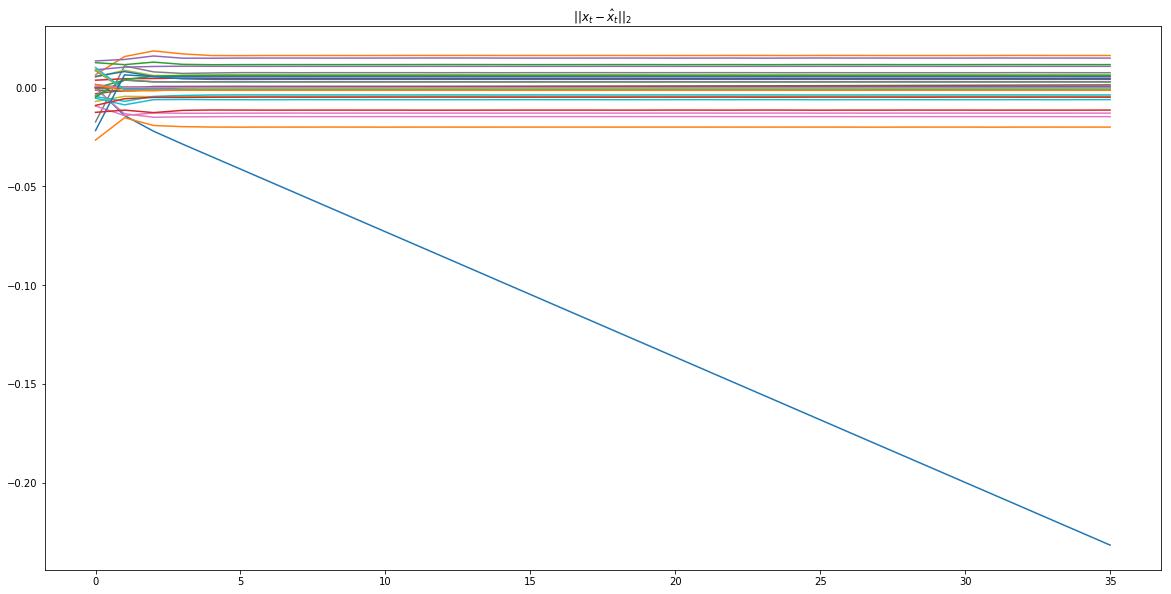

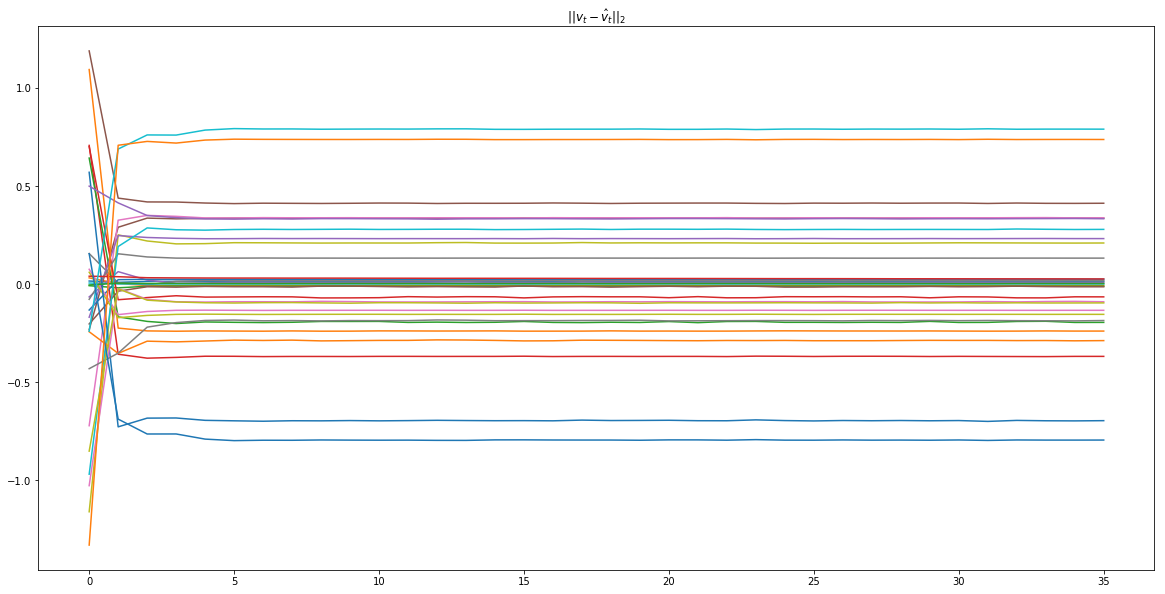

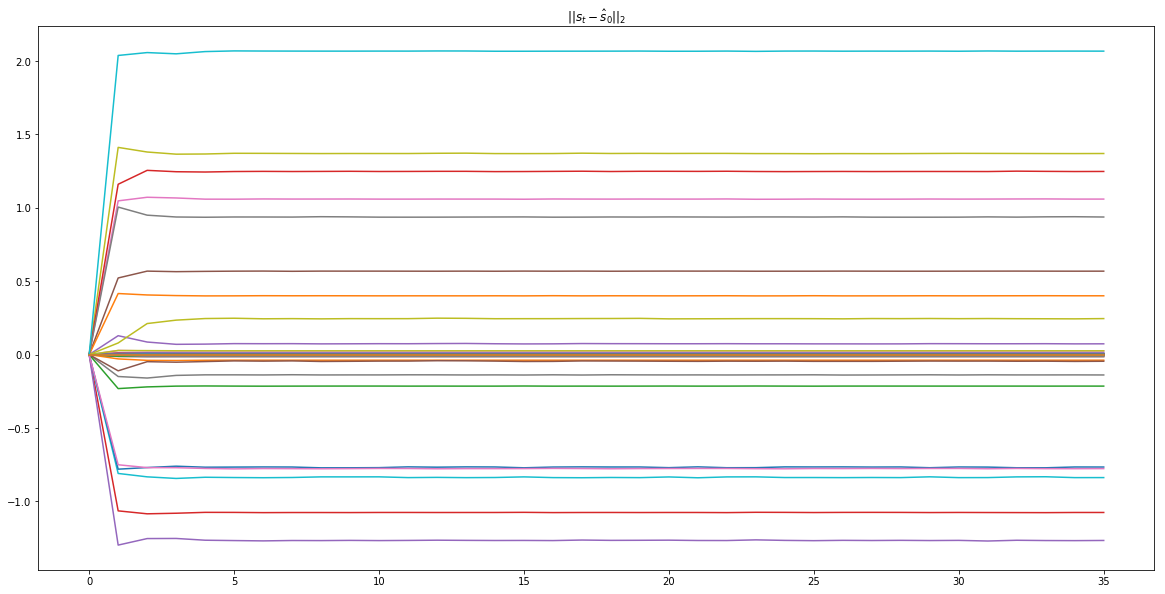

In [13]:
# ||X_t - X_0||
def deviation_plot(data):
    phaselen = env.phaselen
    
    sub = [t for t in range(len(data["qpos"])) if t % (phaselen+1) == 0]
    #print(sub)
    
    x = np.linalg.norm(data["qpos"][:, 1:] - data["rpos"][:, 1:], axis=1)
    xdot = np.linalg.norm(data["qvel"] - data["rvel"], axis=1)
    
    #print((data["qvel"] - data["rvel"])[28])
    #print((data["qpos"] - data["rpos"])[28])

    #xdev = x - x[0]
    
    #ax.plot(np.arange(len(x[sub])), xdev[sub])
    #ax.plot(np.arange(len(x[sub])), np.zeros_like(x)[sub], "--")
    
    #ax.plot(np.arange(len(x[sub])), x[sub])
    #ax.plot(np.arange(len(xdot[sub])), xdot[sub])
    #sns.palplot(sns.color_palette("Blues_d"))
    
    #sns.set_palette(sns.color_palette("Blues_d", 80))

    fig = plt.figure(figsize=(20, 10))
    ax = fig.gca()
    ax.set_title(r"$||x_t - \^{x}_t||_2$")

    
    ax.plot(np.arange(len(xdot[sub])), 
           (data["qpos"] - data["rpos"])[sub])
    
    fig = plt.figure(figsize=(20, 10))
    ax = fig.gca()
    ax.set_title(r"$||v_{t} - \^{v}_{t}||_2$")
    
    ax.plot(np.arange(len(xdot[sub])), 
            (data["qvel"] - data["rvel"])[sub])
    
    fig = plt.figure(figsize=(20, 10))
    ax = fig.gca()
    ax.set_title(r"$||s_t - \^{s}_0||_2$")

    ax.plot(np.arange(len(xdot[sub])), 
            (data["s"] - data["s"][0])[sub])

    
    #print((data["qpos"] - data["rpos"])[sub][-1])
    

data = get_trajectory_data(1000)

deviation_plot(data)

In [11]:
# print(data["qpos"][-1] - data["rpos"][-1])
# print(data["qpos"][-1])
# print(data["rpos"][-1])

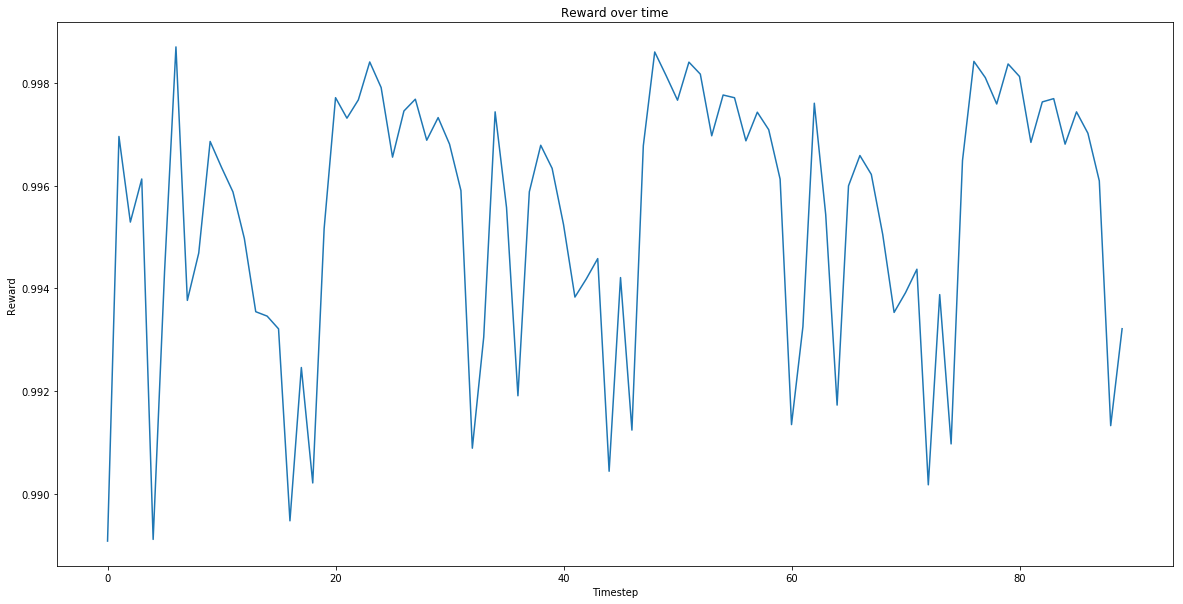

In [12]:
def plot_reward(data):
    fig = plt.figure(figsize=(20, 10))
    ax = fig.gca()
    
    ax.plot(np.arange(len(data["reward"])), data["reward"])
    
    ax.set_ylabel(r"Reward")
    ax.set_xlabel(r"Timestep")
    ax.set_title("Reward over time")

#data = get_trajectory_data(10000)
plot_reward(data)